# KPI Analysis for Original Network

This notebook analyzes the **Original Network** scenario performance. Results are read from the **Original network/results** folder.

## Analysis Overview

This analysis provides:
1. **Bidirectional Flow Analysis**: Speed and waiting time comparison for both directions (E0->E5 and E5->E0)
2. **Vehicle Performance**: Comparison between buses and transversal traffic
3. **KPI Summary**: Key performance indicators for different vehicle categories

In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Original network")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")

# Create results folder if it doesn't exist
if not os.path.exists(RESULTS_DIR):
    print(f"Creating results folder: {RESULTS_DIR}")
    os.makedirs(RESULTS_DIR, exist_ok=True)

# Definition of the two directions
DIR_A_EDGES = ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"]  # Forward (E0 -> E5)
DIR_B_EDGES = ["E5E4", "E4E3", "E3E2", "E2E1", "E1E0"]  # Backward (E5 -> E0)

In [2]:
# ==========================================
# 2. VEHICLE CLASSIFICATION
# ==========================================
def classify_vehicle(veh_id):
    """Classify vehicles based on their ID prefix."""
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    # --- Direction A (E0 -> E5) ---
    if prefix in ['f_7']: 
        return "Bus Dir A (E0->E5)", "Bus", "Dir A"
    
    # --- Direction B (E5 -> E0) ---
    elif prefix in ['f_6']: 
        return "Bus Dir B (E5->E0)", "Bus", "Dir B"
        
    # --- Other categories ---
    elif prefix in ['f_4', 'f_5']:
        return "Other Bus", "Bus", "Other"
    elif prefix in ['f_0', 'f_1', 'f_2', 'f_3']:
        return "Transversal Traffic", "Traffic", "Transversal"
    else:
        return "Background", "Car", "Other"

In [3]:
# ==========================================
# 3. DATA LOADING
# ==========================================
def load_data(data_folder):
    """Load trip and edge data from XML files."""
    trip_path = os.path.join(data_folder, "tripinfo.xml")
    edge_path = os.path.join(data_folder, "bus_results.xml")

    # --- 1. TRIPINFO (Individual vehicles) ---
    trips = []
    if os.path.exists(trip_path):
        tree = ET.parse(trip_path)
        for t in tree.getroot().findall('tripinfo'):
            cat, vtype, route_group = classify_vehicle(t.get('id'))
            
            duration = float(t.get('duration'))
            route_len = float(t.get('routeLength', 0))
            
            # Calculate average trip speed in km/h
            speed_kmh = (route_len / duration) * 3.6 if duration > 0 else 0

            trips.append({
                'id': t.get('id'),
                'category': cat,
                'type': vtype,
                'route_group': route_group,
                'waitingTime': float(t.get('waitingTime')),
                'duration': duration,
                'routeLength': route_len,
                'speed_kmh': speed_kmh
            })
    df_trips = pd.DataFrame(trips)

    # --- 2. EDGE DATA (Roads) ---
    edges_stats = []
    if os.path.exists(edge_path):
        tree = ET.parse(edge_path)
        intervals = tree.getroot().findall('interval')
        if intervals:
            # Use the last interval
            for e in intervals[-1].findall('edge'):
                eid = e.get('id')
                direction = "None"
                order = 99
                
                if eid in DIR_A_EDGES:
                    direction = "Dir A (E0->E5)"
                    order = DIR_A_EDGES.index(eid)
                elif eid in DIR_B_EDGES:
                    direction = "Dir B (E5->E0)"
                    order = DIR_B_EDGES.index(eid)
                
                if direction != "None":
                    speed_ms = float(e.get('speed', 0))
                    wait_sec = float(e.get('waitingTime', 0)) 
                    
                    edges_stats.append({
                        'edge_id': eid,
                        'direction': direction,
                        'order': order,
                        'speed_kmh': speed_ms * 3.6,        # m/s -> km/h
                        'waiting_hours': wait_sec / 3600.0, # seconds -> hours
                        'density': float(e.get('density', 0))
                    })
    
    df_edges = pd.DataFrame(edges_stats)
    if not df_edges.empty:
        df_edges = df_edges.sort_values(by=['direction', 'order'])

    return df_trips, df_edges

In [4]:
# ==========================================
# 4. VISUALIZATION
# ==========================================
def create_dashboard(df_trips, df_edges, output_dir):
    """Create comprehensive KPI dashboards."""
    sns.set_theme(style="whitegrid")
    
    # Separate edge datasets by direction
    df_edges_A = df_edges[df_edges['direction'] == "Dir A (E0->E5)"]
    df_edges_B = df_edges[df_edges['direction'] == "Dir B (E5->E0)"]

    # --- FIGURE 1: EDGE ANALYSIS (SPEED & WAIT) ---
    fig1, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
    fig1.suptitle("Edge Analysis: Bidirectional Flow (km/h & Hours)", fontsize=18, fontweight='bold')

    # Column titles
    axes[0,0].set_title("DIRECTION A (E0 -> E5)", fontsize=14, color='green', fontweight='bold')
    axes[0,1].set_title("DIRECTION B (E5 -> E0)", fontsize=14, color='blue', fontweight='bold')

    # ROW 1: SPEED (km/h)
    if not df_edges_A.empty:
        sns.lineplot(data=df_edges_A, x='edge_id', y='speed_kmh', marker='o', color='green', ax=axes[0,0], linewidth=3)
        axes[0,0].set_ylabel("Speed (km/h)")
        for x, y in zip(range(len(df_edges_A)), df_edges_A['speed_kmh']):
            axes[0,0].text(x, y+0.5, f"{y:.1f}", ha='center', color='green', fontweight='bold')
            
    if not df_edges_B.empty:
        sns.lineplot(data=df_edges_B, x='edge_id', y='speed_kmh', marker='o', color='blue', ax=axes[0,1], linewidth=3)
        axes[0,1].set_ylabel("")
        for x, y in zip(range(len(df_edges_B)), df_edges_B['speed_kmh']):
            axes[0,1].text(x, y+0.5, f"{y:.1f}", ha='center', color='blue', fontweight='bold')

    # ROW 2: TOTAL ACCUMULATED WAITING TIME (Hours)
    if not df_edges_A.empty:
        sns.barplot(data=df_edges_A, x='edge_id', y='waiting_hours', hue='edge_id', palette="Greens", ax=axes[1,0], legend=False, edgecolor='black')
        axes[1,0].set_ylabel("Total Accumulated Wait (Hours)")
        
    if not df_edges_B.empty:
        sns.barplot(data=df_edges_B, x='edge_id', y='waiting_hours', hue='edge_id', palette="Blues", ax=axes[1,1], legend=False, edgecolor='black')
        axes[1,1].set_ylabel("")

    # ROW 3: HEATMAPS (Hours)
    if not df_edges_A.empty:
        matrix_A = df_edges_A[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_A, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,0], cbar=False)
        axes[2,0].set_xlabel("Edge Sequence")
        
    if not df_edges_B.empty:
        matrix_B = df_edges_B[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_B, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,1], cbar_kws={'label': 'Hours'})
        axes[2,1].set_xlabel("Edge Sequence")

    plot_path_1 = os.path.join(output_dir, "edge_analysis_bidirectional.png")
    plt.savefig(plot_path_1, dpi=300)
    print(f"Saved: {plot_path_1}")

    # --- FIGURE 2: BUS vs NETWORK COMPARISON ---
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig2.suptitle("Strategic KPI: Bus Performance Analysis", fontsize=16, fontweight='bold')

    # 1. Waiting Time Comparison
    target_buses = df_trips[df_trips['type'] == 'Bus']
    if not target_buses.empty:
        sns.barplot(data=target_buses, x='category', y='waitingTime', hue='category', palette="viridis", ax=axes[0,0], legend=False)
        axes[0,0].set_title("Avg Bus Trip Waiting Time (Seconds)", fontweight='bold')
        axes[0,0].set_ylabel("Seconds per Trip")
        for c in axes[0,0].containers:
            axes[0,0].bar_label(c, fmt='%.1f', padding=3)

    # 2. Speed Comparison
    comp_groups = ["Bus Dir A (E0->E5)", "Bus Dir B (E5->E0)", "Transversal Traffic"]
    speed_df = df_trips[df_trips['category'].isin(comp_groups)]
    
    if not speed_df.empty:
        sns.boxplot(data=speed_df, x='category', y='speed_kmh', hue='category', palette="Set2", ax=axes[0,1], legend=False)
        axes[0,1].set_title("Speed Comparison: Bus vs Cross Traffic", fontweight='bold')
        axes[0,1].set_ylabel("Mean Trip Speed (km/h)")

    # 3. Duration Breakdown - Bottom Left
    dur_df = df_trips.groupby('category')['duration'].mean().reset_index()
    dur_df = dur_df[dur_df['category'].isin(comp_groups + ["Other Bus"])]
    
    if not dur_df.empty:
        sns.barplot(data=dur_df, x='category', y='duration', hue='category', palette="coolwarm", ax=axes[1,0], legend=False)
        axes[1,0].set_title("Average Trip Duration", fontweight='bold')
        axes[1,0].set_ylabel("Duration (seconds)")
        for c in axes[1,0].containers:
            axes[1,0].bar_label(c, fmt='%.1f', padding=3)

    # 4. Text Summary Box - Bottom Right
    axes[1,1].axis('off')
    
    text_str = "KPI SUMMARY REPORT\n" + "="*35 + "\n"
    
    # Global network summary
    text_str += "GLOBAL NETWORK SUMMARY:\n"
    text_str += f"  - Total Vehicles: {len(df_trips)}\n"
    text_str += f"  - Avg Waiting:    {df_trips['waitingTime'].mean():.2f} s\n"
    text_str += f"  - Avg Speed:      {df_trips['speed_kmh'].mean():.2f} km/h\n"
    text_str += "-"*35 + "\n"

    # Category breakdown
    for cat in comp_groups:
        subset = df_trips[df_trips['category'] == cat]
        if not subset.empty:
            avg_wait = subset['waitingTime'].mean()
            avg_speed = subset['speed_kmh'].mean()
            avg_duration = subset['duration'].mean()
            count = len(subset)
            text_str += f"{cat}:\n"
            text_str += f"  - Vehicles:  {count}\n"
            text_str += f"  - Avg Speed: {avg_speed:.2f} km/h\n"
            text_str += f"  - Avg Wait:  {avg_wait:.2f} s\n"
            text_str += f"  - Avg Dur:   {avg_duration:.2f} s\n\n"
    
    axes[1,1].text(0.05, 0.95, text_str, fontsize=10, fontfamily='monospace', verticalalignment='top', 
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

    plot_path_2 = os.path.join(output_dir, "kpi_analysis_performance.png")
    plt.savefig(plot_path_2, dpi=300)
    print(f"Saved: {plot_path_2}")
    plt.show()

## KPI Analysis Results

This section loads and visualizes the performance data from the Original Network scenario.

Reading data from: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network
Saving plots to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results

Loaded 7315 trips and 10 edge records
Saved: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results\edge_analysis_bidirectional.png
Saved: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network\results\kpi_analysis_performance.png


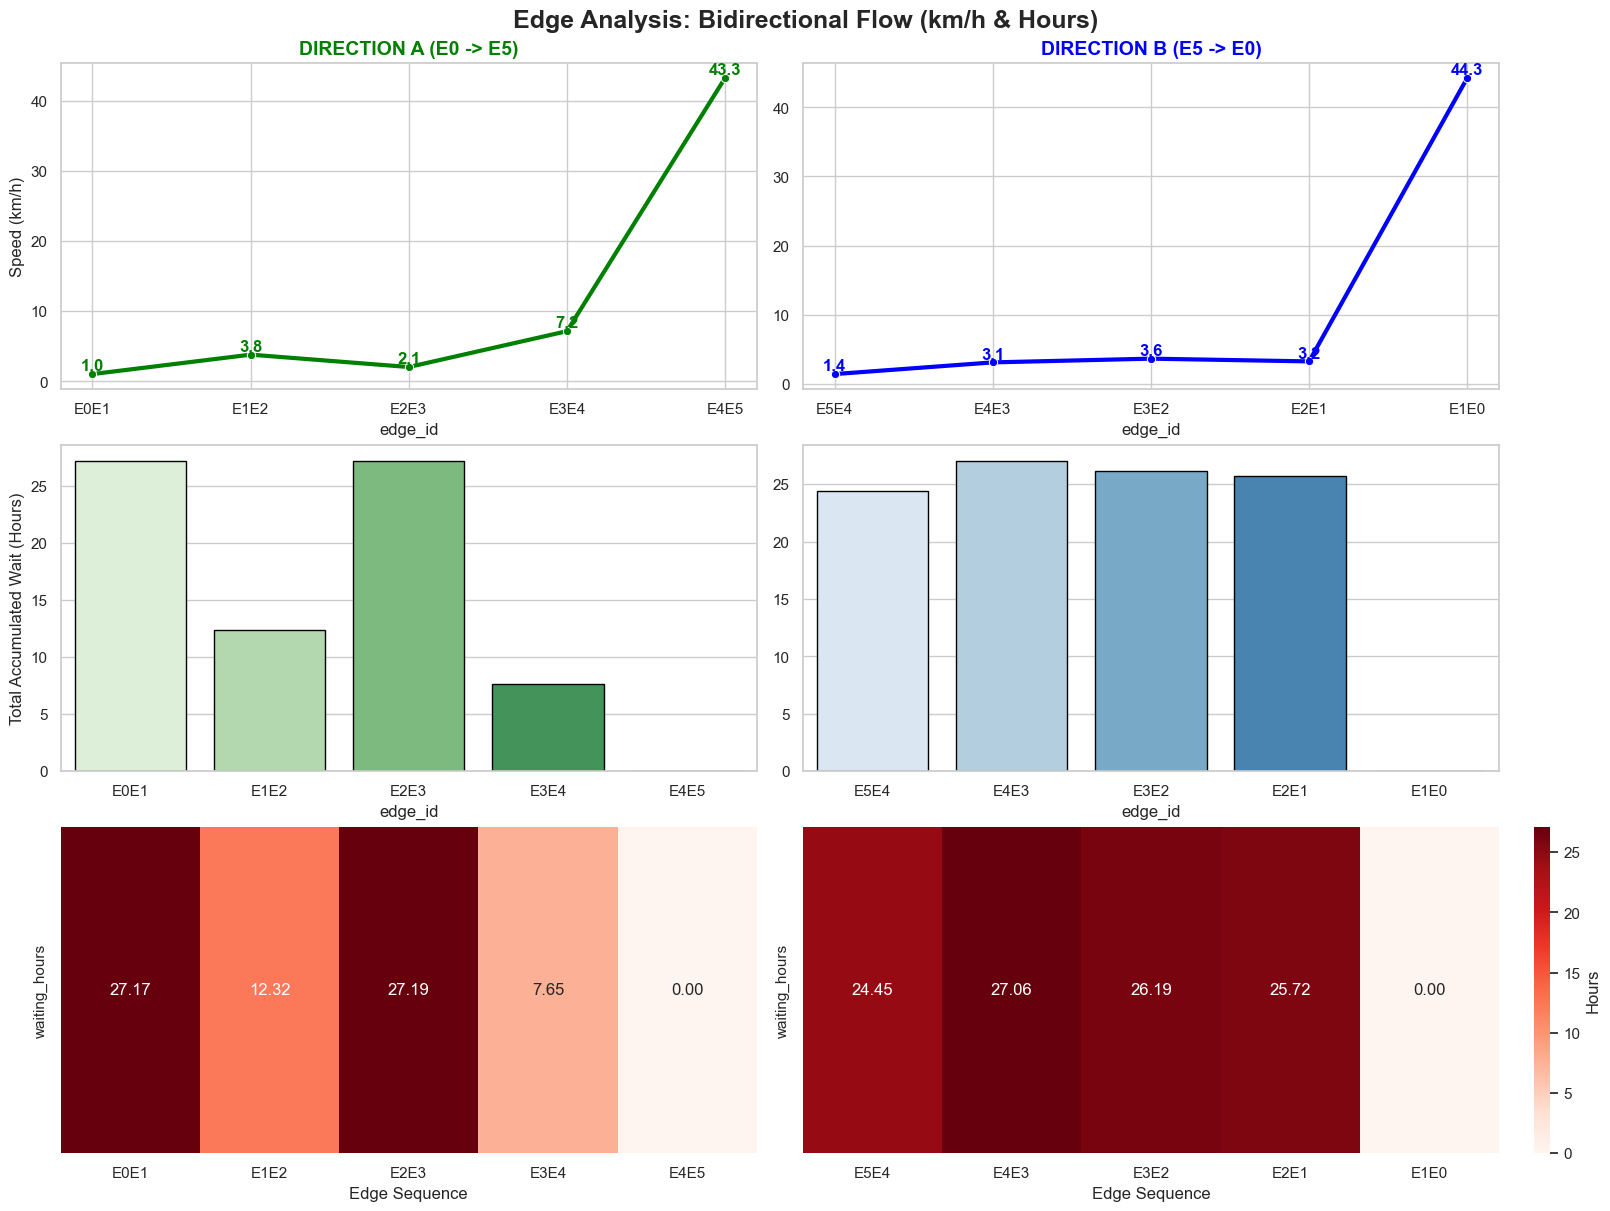

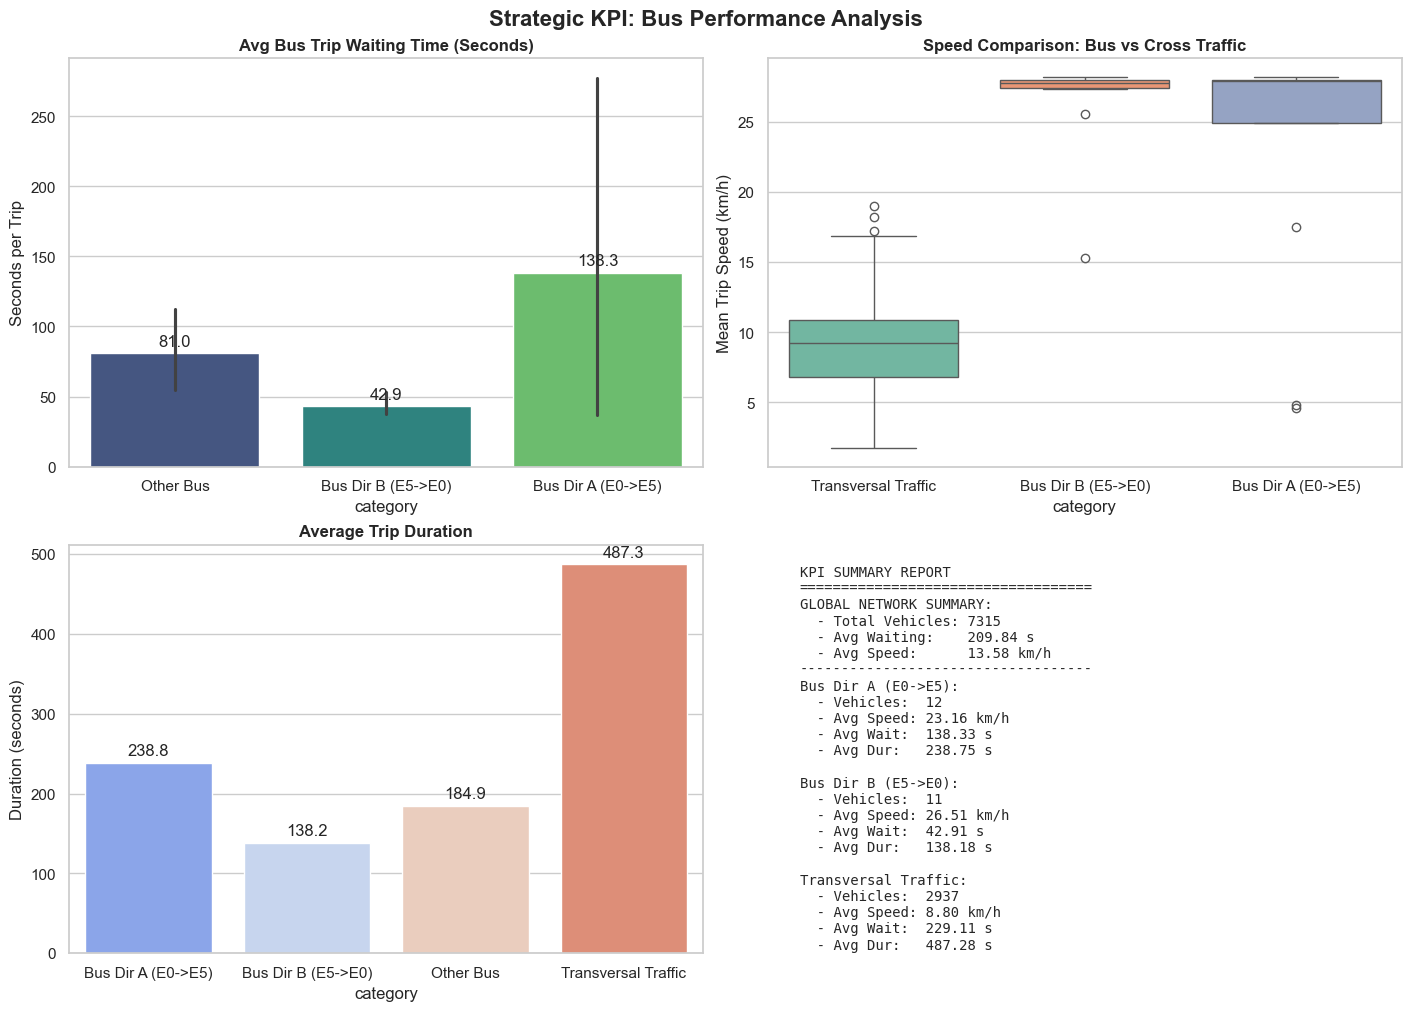


Analysis completed successfully!


In [5]:
# ==========================================
# 5. EXECUTION
# ==========================================
print(f"Reading data from: {SCENARIO_DIR}")
print(f"Saving plots to: {RESULTS_DIR}")

try:
    trips, edges = load_data(SCENARIO_DIR)
    
    if trips.empty:
        print("\nWARNING: No trip data found.")
        print("Please ensure the simulation has been run.")
        print(f"Expected file: {os.path.join(SCENARIO_DIR, 'tripinfo.xml')}")
    else:
        print(f"\nLoaded {len(trips)} trips and {len(edges)} edge records")
        create_dashboard(trips, edges, RESULTS_DIR)
        print("\nAnalysis completed successfully!")
        
except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()